# WORK IN PROGRESS

# Brief Intro to Bayesian Data Analysis

<i><center>Alfred J. Reich, Ph.D.</center></i>

> <i>"We could call Bayesian data analysis 'statistics using conditional probability', but that wouldn’t put the butts in the seats."</i>  
> <p>-- Andrew Gelman</p>

<b><i>Probability Theory</i></b> is a subfield of Mathematics that is concerned with mathematical models of random phenomena.  <i><b>Mathematical Statistics</b></i> is a subfield of Probability Theory concerned with the derivation of features of a probability model based on a set of <b>Random Variables (RV)</b>, usually <b>independent and identically distributed (i.i.d.)</b>, from the model.  <i><b>Applied Statistics</b></i> utilizes the results of Mathematical Statistics by replacing the set of RVs with actual observed data to make <b>statistical inferences</b>.

This notebook provides a very brief look at the Bayesian approach to statistical inference, <b>Bayesian Data Analysis (BDA)</b>.

The interpretation and subsequent conduct of statistical analyses has been the subject of debate for many decades, even centuries.  In the 20th century, the debate was mostly over the <b>Frequentist</b> vs. <b>Fisherian</b> approaches. Here, I'll refer to both of these approaches, together, as the <b>Classical</b> approach.

The <b>Bayesian</b> approach was also around during that time, but did not become practical until the 1990s with the advent of efficient simulation methods, such as <b>Markov Chain Monte Carlo (MCMC)</b>, and widespread access to powerful computers. Today, the debate goes on, but now it is more often between the Classical and Bayesian approaches.

## Making Assumptions

> <i>"All models are wrong, but some are useful"</i>
> <p>-- George Box</p>

Data analyses can be viewed in terms of the assumptions made about the nature of the data being analyzed. Broadly speaking, there are three levels of assumptions (listed below) where each level increases the assumptions made, and correspondingly increases the possibility that the assumptions are wrong.

<b>1. Exploratory Data Analysis</b> -- No probability model; just descriptive statistics
> Examples include: Average, Median, Quantiles, Range, Variance, Minimum/Maximum, Histogram, and various other plots and charts

<b>2. Classical Data Analysis</b> -- Probability model with fixed parameters

>$$X \sim F(x;\theta)$$
><p>Assumes a random variable, $X$, with a probability distribution, $F$ and a fixed parameter $\theta$:
><p><i>(Note: $x$, $X$, and $\theta$ can be scalars or vectors.)</i></p>

<b>3. Bayesian Data Analysis</b> -- Probability model with random parameters and their own models

>$$X \sim F(x;\Theta)$$
><p>$$\Theta \sim G(\theta;\gamma)$$</p>
><p>Assumes a random variable, $X$, with a probability distribution, $F$, and
>random parameter, $\Theta$, with its own distribution, $G$, and (usually) fixed parameter, $\gamma$, sometimes called a hyper-parameter.</p>
><p>$G$ is called a <b><i>prior</i></b> distribution.</p>

## An Example

Suppose we conduct a real-world experiment consisting of a series of $n$ independent trials, where each trial results in either a <i>Success</i> or <i>Failure</i>, and the probability of a Success on any one trial is an unknown value, $\theta$, where $0 \le \theta \le 1$.

The outcome of the experiment is the total number of successful trials, $K$, out of $n$ tries.  This type of probability model is known as a <b>Binomial</b> model. By the way, $n$ is not a parameter; it is a known, fixed value and, and represents the number of observations (trials) we make.

>$$K \sim Binomial(n; \theta) \equiv f_n(k;\theta) = \binom{n}{k} \theta^k(1-\theta)^{n-k}$$
><p>where</p>
><p>$k \in \{0,1,2,...,n\}$ -- Number of successes in n trials (the outcome)</p>
><p>$\theta \in [0,1]$ -- The probability of success for each trial</p>
><p>$n \in \{1,2,3,...\}$ -- The fixed number of trials conducted</p>

Suppose further that, after conducting the $n$ trials, we observed a total of $K=k_{obs}$ successes. $0 \le k_{obs} \le n$.

We don't know the value of $\theta$, but let's assume that $n$ and $k_{obs}$ have the following values:

In [1]:
n = 20  # Number of trials in our real-world experiment
k_obs = 6  # Number of observed successes in our real-world experiment

In [2]:
print(f"Then, a reasonable estimate of p is k_obs/n = {k_obs}/{n} = {k_obs/n}")

Then, a reasonable estimate of p is k_obs/n = 6/20 = 0.3


In <b>Frequentist</b> (or <b>Classical</b>) data analysis, this estimate is the <b>Maximum Likelihood Estimate (MLE)</b> of $\theta$.  We won't go into MLEs here, but let's just say that the MLE provides us with, in some sense, an optimal estimate of a fixed parameter.

### Going Beyond the Classical Approach

Since we're dealing with random behavior here, any value of $\theta$, where $0 \lt \theta \lt 1$, could result in $k_{obs}$ successes.

Some values of $\theta$ will be more likely to produce $k_{obs}$ successes than other values.

Let's see what happens for a single case, where we generate a random Uniform(0,1) value, $\theta$, and then use it to generate a $Binomial(n; \theta)$ random value, $k$, where $n$ is defined as shown earlier.

Our result should approximate the expectation of $K$:
<p>$$E[K]=n\theta$$

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize


Random Uniform(0,1) ==> 0.202

Random Binomial(20, 0.202) ==> k = 7 successes (expected 4)


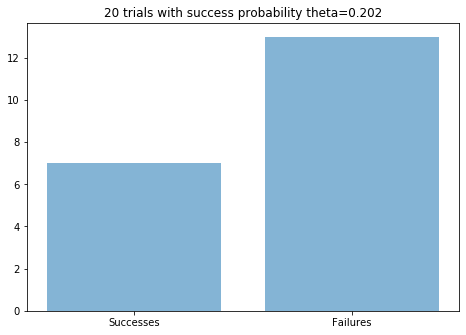

In [16]:
from scipy.stats import uniform, binom

theta = uniform.rvs()  # generates a single Uniform(0,1) random value
k = binom.rvs(n, theta) # generates a single Binomial(n, theta) random value
result = [k, n-k]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Successes', 'Failures']
ax.bar(labels, result, alpha=0.55)
plt.title(f"{n} trials with success probability theta={theta:0.3f}")
print(f"\nRandom Uniform(0,1) ==> {theta:0.3f}")
print(f"\nRandom Binomial({n}, {theta:0.3f}) ==> k = {k} successes (expected {int(round(n*theta))})")

But, what we're really interested in are values of $\theta$ that result in $K = k_{obs}$, our previously observed number of successes.

So, let's try some other values of $\theta$ -- a lot of other values -- and keep track of the ones that result in $k_{obs}$ successes.  Essentially, what we'll arrive at is the conditional probability:

$${Pr}(\theta | K = k_{obs})$$

To do this, we'll work with two lists of $\theta$'s:

* <b><i>priors</i></b>: a list of $m$ random numbers, chosen uniformly between 0 and 1

* <b><i>posteriors</i></b>: the subset of the priors that, when used as the values of $\theta$ in simulations of $n$ trials, result in $k_{obs}$ successes

In the code below, generating the priors list is easy, but the posteriors list takes longer, so we'll time it using <i>%time</i>.

And, we'll count the number of priors that result in $k_{obs}$ successes, because very few will, which is why such a large number of priors is used below.

<i>NOTE: The code here is pedagogical, not practical.  Later, we'll show how to use more efficient simulation methods, such as <b>Markov Chain Monte Carlo (MCMC)</b>, a method that has made Bayesian Data Analysis (BDA) a practical tool.</i>

In [17]:
from scipy.stats import uniform, binom

m = 500_000  # Number of priors

# Generate Priors
priors = list(uniform.rvs(size=m))

# Generate Posteriors
%time posteriors = [p for p in priors if binom.rvs(n,p)==k_obs]

print(f"\nThere were {len(posteriors)} matches out of {m} priors. (Only {100*len(posteriors)/m:0.2}% matched)")

CPU times: user 17.8 s, sys: 290 ms, total: 18.1 s
Wall time: 16.9 s

There were 23773 matches out of 500000 priors. (Only 4.8% matched)


Now, let's look at the two lists, plotted as histograms and scaled to be density functions.

#### Priors Histogram

The histogram of the priors list should look like the Uniform(0,1) probabilty density function.

And it does.

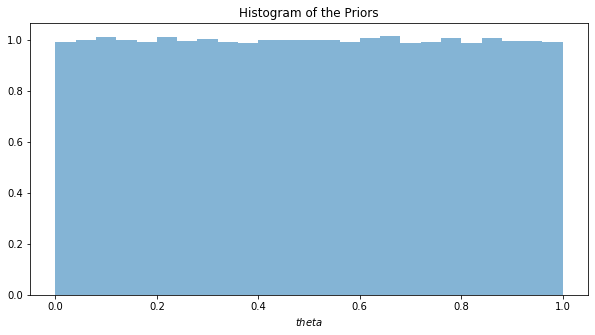

In [18]:
hbins = 25  # Number of bins for histograms
figsize(10,5)
plt.xlabel("$theta$")
plt.title(f"Histogram of the Priors")
_ = plt.hist(priors, bins=hbins, density=True, alpha=0.55)

#### Posteriors Histogram

The histogram of the posteriors list more interesting than the priors list.

We can see that it concentrates near the MLE value we computed earlier.

But, unlike the MLE, which is a point estimate of $\theta$, here we see a probability density for $\theta$.

And we should, because, essentially, we assumed that $\theta$ is a random variable with a Uniform(0,1) marginal distribution.  That is, $Pr(\theta) \equiv $ Uniform(0,1).

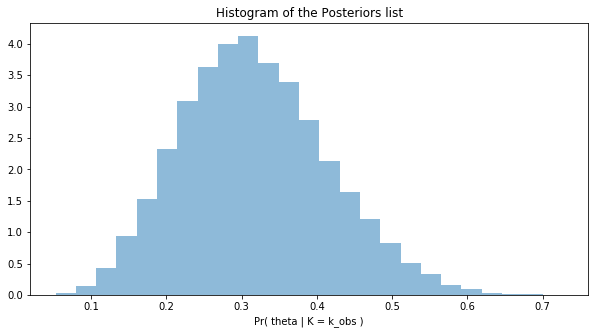

In [24]:
plt.xlabel("Pr( theta | K = k_obs )")
plt.title(f"Histogram of the Posteriors list")
_ = plt.hist(posteriors, bins=hbins, density=True, alpha=0.5)

Now, the next part of our example is not something we would necessarily do as part of a BDA, but we're doing it to show that the posteriors here match theoretical results that we will describe later.

So, what we'll do now is search for a continuous distribution that best matches the data in the posteriors list.

#### Posterior Distribution (Empirically Found)

SciPy supports about 90 continuous probability distributions.  The module, <b>fitdist</b>, finds the continuous distribution that best fits an input dataset (in this case, the posteriors).  For expediency, only the most common distributions (~18) are examined in the function call below.

In [25]:
import fitdist as fd  # https://github.com/alreich/fitdist
import warnings
warnings.simplefilter("ignore")

raw_fit_results = fd.find_best_fit_distributions(posteriors,
                                                 dist_names = fd.common_cont_dist_names,
                                                 goodness_of_fit_pvalue = 0.50,
                                                 drop_dist_names = []
                                                )

raw_fit_results

[['powernorm',
  (0.14051498284632363, 0.1932392815783172, 0.04824002686774969),
  0.7276442039826883],
 ['beta',
  (6.7578772722650395,
   14.266511506402459,
   0.003993221018784775,
   0.9753500700662832),
  0.7118748752846156]]

The raw fit results, above, is a list of sublists, where each sublist consists of the following:
* the distribution name
* a list of the MLE parameter estimates (in scipy.stat's defined order)
* and the Kolmogorov-Smirnov Goodness-of-Fit p-value

The first item in the list is the best fitting distribution.

We'll extract the parameters from the raw results and interpret their meaning as follows:

In [26]:
index = 1
name = raw_fit_results[index][0]
mle = raw_fit_results[index][1]
mle_rounded = tuple(map(lambda x: int(round(x)), mle))
shape_a, shape_b, location, scale = mle_rounded
print(f"Best Fit to Posterior data: {name}({shape_a},{shape_b}) over the interval [{location}, {scale}])")

Best Fit to Posterior data: beta(7,14) over the interval [0, 1])


Now, let's compare the empirically found beta distribution to the posteriors histogram by plotting them together.

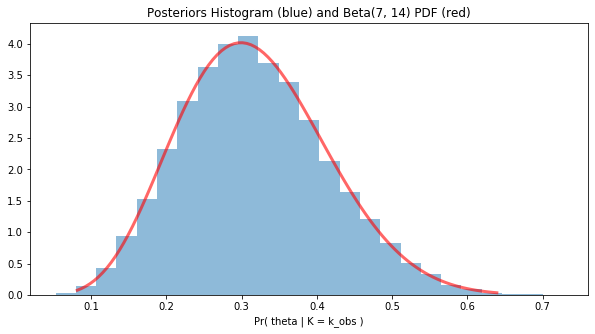

In [27]:
from scipy.stats import beta
from numpy import linspace

plt.xlabel("Pr( theta | K = k_obs )")
plt.title(f'Posteriors Histogram (blue) and Beta({shape_a}, {shape_b}) PDF (red)')

x = linspace(beta.ppf(0.001, *mle), beta.ppf(0.999, *mle), 100)
plt.plot(x, beta.pdf(x, *mle), 'r-', lw=3, alpha=0.6)
_, _, _ = plt.hist(posteriors, hbins, density=True, alpha=0.5)

Sampling 4 chains: 100%|██████████| 42000/42000 [00:03<00:00, 12865.49draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb689c96790>,
      dtype=object)

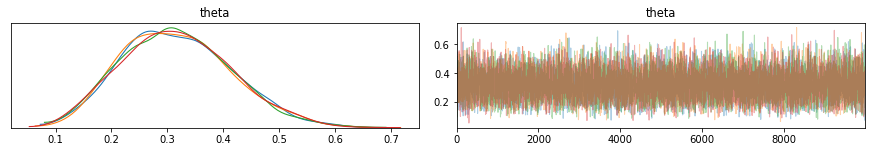

In [28]:
import pymc3 as pm

model = pm.Model()

with model:
    theta = pm.Beta("theta", alpha=1, beta=1 )
    k = pm.Binomial("k", p=theta, n=n, observed=k_obs)
    num_samples = 10_000
    tr = pm.sample(num_samples, step=pm.Metropolis(), progressbar=True )
    #tr = pm.sample(num_samples, progressbar=True )

pm.traceplot(tr)

In [29]:
model

In [30]:
frac = 0.8
int(frac * num_samples)

8000

In [31]:
len(tr['theta'])

40000

In [33]:
theta_samples = tr['theta', 6000:]

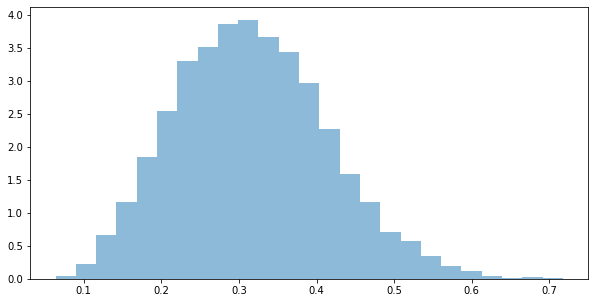

In [34]:
_, _, _ = plt.hist(theta_samples, hbins, density=True, alpha=0.5)

In [35]:
map_estimate = pm.find_MAP(model=model)
map_estimate['theta']

logp = -3.2978, ||grad|| = 4: 100%|██████████| 6/6 [00:00<00:00, 2087.76it/s]


array(0.29999954)

In [37]:
pymc3_fit_results = fd.find_best_fit_distributions(theta_samples,
                                                   dist_names = fd.common_cont_dist_names,
                                                   goodness_of_fit_pvalue = 0.10,
                                                   drop_dist_names = []
                                                  )

pymc3_fit_results

[['exponweib',
  (1.3731192610882292,
   2.483018690928371,
   0.05103293538007207,
   0.268459323327741),
  0.35934091287507225],
 ['powerlognorm',
  (828.5866629401403,
   1.0813856928481012,
   0.03635255649996609,
   8.216786447809906),
  0.17851254219802667],
 ['beta',
  (5.758890774105518,
   11.82109977908228,
   0.022930738036206107,
   0.8959882011480925),
  0.1345349378525674]]

In [38]:
pm_index = 2
pm_name = pymc3_fit_results[pm_index][0]
pm_mle = pymc3_fit_results[pm_index][1]
pm_mle_rounded = tuple(map(lambda x: int(round(x)), pm_mle))
pm_shape_a, pm_shape_b, pm_location, pm_scale = pm_mle_rounded
print(f"PyMC3 Fit to sampled data: {pm_name}({pm_shape_a},{pm_shape_b}) over the interval [{pm_location}, {pm_scale}])")

PyMC3 Fit to sampled data: beta(6,12) over the interval [0, 1])


# Scratch Work Below

SPOILER ALERT: According to theoretical results, that we haven't spoken about yet, the best fitting distribution should be the <b>beta</b> distribution.

More on the beta distribution can be found at the [SciPy beta distribution documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html) or on [Wikipedia's beta distribution page](https://en.wikipedia.org/wiki/Beta_distribution).

The <b>Uniform(0,1)</b> prior, used above, is equivalent to a <b>Beta(1,1)</b> prior.  And, since the beta prior is conjugate with binomial likelihoods, the posterior should be a <b>Beta( 6 + 1, 20 - 6 + 1 ) = Beta(7,15)</b> which is close to what we obtained above.

Here's the math:

First of all, the Uniform distribution is equivalent to a Beta distribution:
<p><center>$U(0,1) \equiv Beta(1,1)$</center></p>
<p>Then, assuming the <i>prior</i> and the <i>likelihood</i> are as follows:</p>
<p><center><u>Prior</u>:  $\pi(\theta) \sim Beta(\alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$</center></p>
<p><center><u>Likelihood</u>:  $Y \sim Binomial(n,k,\theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$</center></p>
<p>So, multiplying the two, followed by some algebraic manipulation, we arrive at:</p>
<p><center><u>Posterior</u>:  $\pi(\theta \mid Y=k) \sim Beta(k+\alpha, n-k+\beta)$</center></p>

The following three subsections go into a bit more depth on each of these three categories.

### 1. Exploratory Data Analysis

No probability model; just quantitative descriptions of a dataset ("statistics")

#### Examples

* Average
* Median
* Quantiles
* Range
* Minimum/Maximum
* Histogram 

### 2. Classical Data Analysis

The probability model consists of a random variable, $X$, with a probability distribution, $F$ and a fixed parameter $\theta$:

$X \sim F(x;\theta)$


#### Example #2

<i><u>Discrete Case</u></i>

In this example the outcomes are integer values, so we'll use $K$ and $k$ instead of $X$ and $x$ for the random variable and its outcome value, resp.

The <b>binomial probability distribution</b>, $Binomial_n(k;\theta)$, is a discrete distribution representing the probability of $k$ successes in $n$ independent trials, where the probability of success on each individual trial is $\theta$, where $0 \le \theta \le 1$.

then $K \sim Binomial_n(k;\theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$
> <p>where</p>
> <p>$n \in \{1,2,3,...\}$ -- The fixed number of trials</p>
> <p>$k \in \{0,1,2,...,n\}$ -- Number of successes in n trials (the outcome)</p>
> <p>$\theta \in [0,1]$ -- The fixed probability of success for each trial</p>


### 3. Bayesian Data Analysis

<i>(NOTE: This starts out like the Classical approach, except that it goes a step further by assuming that the parameter itself, $\theta$, has a model.)</i>

Assumes a random variable, $X$, with a specific probability distribution, $F$, and <b>random</b> parameter, $\Theta$, with its own distribution, $G$, and fixed parameter, $\gamma$, sometimes called a hyper-parameter:

$X \sim F(x;\Theta)$ where $\Theta \sim G(\theta;\gamma)$

$G$ is called a <b><i>prior</i></b> distribution.

#### Example #3

<i><u>Discrete Case</u></i>

Building on the discrete model in Example #2, above, except that instead of a fixed success probability, $\theta$, here it is assumed to be a random variable, $\Theta$, with its own distribution, a <b>Beta distribution</b>, $Beta(\theta; \alpha, \beta)$, where $\theta \in [0,1]$, $\alpha > 0$, and $\beta > 0.$

$K \sim Binomial_n(k; \Theta) \equiv \binom{n}{k} \Theta^k(1-\Theta)^{n-k}$

$\Theta \sim Beta(\theta; \alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$

> <p>where</p>
> <p>$n \in \{1,2,3,...\}$ -- Number of trials (a fixed value)</p>
> <p>$k \in \{0,1,2,...,n\}$ -- Number of successes</p>
> <p>$\theta \in [0,1]$ -- The fixed probability of success for each trial
> <p>$\alpha > 0$ and $\beta > 0$</p>

## Scatch Work

<b><i>Probability Theory</i></b> is a subfield of Mathematics that is concerned with mathematical models of random phenomena.  <i><b>Mathematical Statistics</b></i> is a subfield of Probability Theory concerned with the derivation of features of a probability model based on a set of <b>Random Variables (RV)</b> from the model.  <i><b>Applied Statistics</b></i> utilizes the results of Mathematical Statistics by replacing the set of RVs with actual observed data to make <b>statistical inferences</b>.

In [23]:
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()